# Import all necessary libraries

In [70]:
import os
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection.validation import cross_validate
from collections import defaultdict

In [71]:
df = pd.read_csv("/content/drive/MyDrive/GL/Recommendation/ratings_Electronics.csv", names=["user_id", "product_id", "ratings", "timestamp"])  
df.drop(columns=["timestamp"], inplace=True)
df.head()

,user_id,product_id,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [72]:
print(f"There are a total of {df['user_id'].nunique()} unique user_ids")
print(f"There are a total of {df['product_id'].nunique()} unique product_ids")

There are a total of 4201696 unique user_ids
There are a total of 476002 unique product_ids


This is a huge dataset so in order to prevent memory issue, we will reduce the dataset to 20% the original size.

In [73]:
df = df.sort_values(by="user_id").head(int(.2*df.shape[0]))

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564896 entries, 3588866 to 2275059
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1564896 non-null  object 
 1   product_id  1564896 non-null  object 
 2   ratings     1564896 non-null  float64
dtypes: float64(1), object(2)
memory usage: 47.8+ MB


In [75]:
df.isna().sum()

user_id       0
product_id    0
ratings       0
dtype: int64

There are no null values in our dataset.

In [76]:
df.describe()

,ratings
count,1.564896e+06
mean,4.011600e+00
std,1.382083e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [77]:
df.groupby("product_id")["ratings"].mean().sort_values(ascending=False).head()

product_id
B00852X8B8    5.0
B001MLBOJC    5.0
B00805LAS8    5.0
B00805O5AI    5.0
B00805T0LW    5.0
Name: ratings, dtype: float64

The above products have an average rating of 5.0

In [78]:
df.groupby("product_id")["ratings"].count().sort_values(ascending=False).head()  

product_id
B0074BW614    3665
B00DR0PDNE    3271
B007WTAJTO    2812
B006GWO5WK    2460
B0019EHU8G    2430
Name: ratings, dtype: int64

The above products are the top 5 most rated products.

In [79]:
xx = df.groupby("user_id")["product_id"].count().reset_index().sort_values(by="product_id", ascending=False)
xx

,user_id,product_id
755206,A1ODOGXEYECQQ8,380
229970,A17BUUBOU0598B,261
77779,A12DQZKRKTNF5E,252
392540,A1CMD08Z49PGKQ,221
595272,A1J75JJ0Q2OEJN,218
...,...,...
332416,A1ANLRYB668QP,1
332418,A1ANLTKULFA0MP,1
332422,A1ANLZNJ0T9SKR,1
332425,A1ANM4R0UK8GCO,1


The user **A1ODOGXEYECQQ8** has given the maximum number of reviews.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


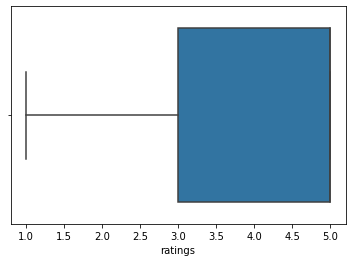

In [80]:
sns.boxplot(df["ratings"]);

Most of the reviews are between 3 to 5 stars.

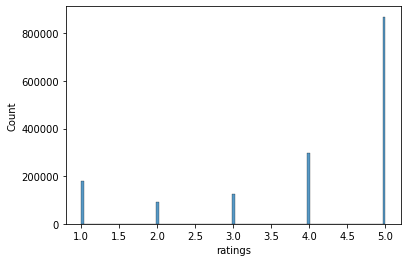

In [81]:
sns.histplot(df['ratings']);

## Create a subset of data with users who have given 50 or more ratings

In [82]:
x = df.groupby(["user_id"])["product_id"].count()
df_train = df[df["user_id"].isin(x[x>=50].reset_index()["user_id"])]

1. Read and explore the given dataset. ( Rename column/add headers, plot
histograms, find data characteristics) ( 3 Marks)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example,
keep the users only who has given 50 or more number of ratings ) -(5 Marks)
3. Build Popularity Recommender model. ( 15 marks)
4. Split the data randomly into a train and test dataset. ( For example, split it in
70/30 ratio) ( 2 marks)
5. Build Collaborative Filtering model. ( 20 marks)
6. Evaluate the above model. ( Once the model is trained on the training data, it
can be used to compute the error (like RMSE) on predictions made on the test
data.) You can also use a different method to evaluate the models. ( 5 marks)
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new
products to each user based on his/her habits, we will recommend 5 new
products. ( 10 marks)
8. Summarise your insights. ( 10 marks)

# Popularity based model

In [83]:
ratings_mean_count = df.groupby("product_id").agg({"ratings" : "mean", "user_id" : "count"}).sort_values(by=["user_id", "ratings"], ascending=False).head(10)
ratings_mean_count

,ratings,user_id
product_id,,
B0074BW614,4.499591,3665
B00DR0PDNE,3.896362,3271
B007WTAJTO,4.420697,2812
B006GWO5WK,4.340650,2460
B0019EHU8G,4.744444,2430
B003ELYQGG,4.403104,2255
B007R5YDYA,4.683777,2065
B00622AG6S,4.383075,1997
B003ES5ZUU,4.720403,1985


The above code gives us the highly rated movies sorted by the number of ratings given which can be called as a popularity based recommendation since these products are the most popular and can be recommended to a cold-start user.

# Collaborative Filtering model

In [84]:
reader = Reader(line_format="user item rating", rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df_train, reader)
trainset, testset = train_test_split(data, test_size=.30)

# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [85]:
test_pred = algo.test(testset)

Creating a model using the surprise package to create a user-based collaborative filtering model.

In [86]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_2 = pd.DataFrame(test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_2['Iu'] = df_2.uid.apply(get_Iu)
df_2['Ui'] = df_2.iid.apply(get_Ui)
df_2['err'] = abs(df_2.est - df_2.rui)
df_2["was_impossible"] = df_2["details"].apply(lambda x : x["was_impossible"])
df_2["actual_k"] = df_2["details"].apply(lambda x : x["actual_k"] if "actual_k" in x else None)
df_2.drop(columns=["details"], inplace=True)

best_predictions = df_2.sort_values(by='err')
worst_predictions = df_2.sort_values(by='err')[-20:]

In [87]:
best_predictions.head()

,uid,iid,rui,est,Iu,Ui,err,was_impossible,actual_k
4796,A10O7THJ2O20AG,B000QUUFRW,5.0,5.0,59,12,0.0,False,3.0
121,A12O5SEIF162P8,B009NHWVIA,5.0,5.0,40,11,0.0,False,1.0
6827,A19FRW264WZTGP,B00HMREOLK,5.0,5.0,39,2,0.0,False,1.0
5073,A1JZFGZEZVWQPY,B00F0H88AC,4.0,4.0,72,1,0.0,False,0.0
5199,A1KKE6VX8VPWZK,B002FU5QM0,5.0,5.0,60,2,0.0,False,1.0


In [88]:
worst_predictions.head()

,uid,iid,rui,est,Iu,Ui,err,was_impossible,actual_k
2420,A11KZ906QD08C5,B0006OCEFY,1.0,4.391608,143,1,3.391608,False,0.0
6115,A1BT6TL7UCIC5Y,B003WM2N94,1.0,4.398230,113,1,3.398230,False,0.0
5509,A1DO9LRCO23EOM,B00AW48DS0,1.0,4.405405,37,4,3.405405,False,0.0
3626,A1D9V11QUHXENQ,B004LSNF04,1.0,4.473684,38,4,3.473684,False,0.0
532,A1D9V11QUHXENQ,B002I636XM,1.0,4.473684,38,1,3.473684,False,0.0


The above code shows us the prediction vs actual values of ratings. The best predictions are filtered out by getting the difference between the actual and predicted ratings as **err** and sorting in ascending order. The ones at the bottom with the highest **err** are the worst predictions.

In [89]:
cross_validate(algo, data, measures=["rmse", "mae", "mse"], cv=5, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE, MSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0632  1.0563  1.0891  1.0854  1.0742  1.0737  0.0125  
MAE (testset)     0.7996  0.7996  0.8224  0.8138  0.8129  0.8097  0.0089  
MSE (testset)     1.1305  1.1158  1.1861  1.1782  1.1540  1.1529  0.0269  
Fit time          0.12    0.10    0.13    0.13 

{'fit_time': (0.11535525321960449,
  0.1033179759979248,
  0.13199687004089355,
  0.12687468528747559,
  0.09707450866699219),
 'test_mae': array([0.7996329 , 0.79958678, 0.8224091 , 0.81384751, 0.81294835]),
 'test_mse': array([1.13049201, 1.11576264, 1.18613529, 1.1781802 , 1.15395622]),
 'test_rmse': array([1.06324598, 1.05629666, 1.08909839, 1.08544009, 1.07422354]),
 'test_time': (0.0508573055267334,
  0.0496828556060791,
  0.056667327880859375,
  0.05838727951049805,
  0.048005104064941406)}

In [90]:
accuracy.rmse(test_pred, verbose=True)
accuracy.mae(test_pred, verbose=True)
accuracy.mse(test_pred, verbose=True)

RMSE: 1.0504
MAE:  0.7979
MSE: 1.1034


1.1034412873423884

# Top - 5 recommendations for all users

Let's create an SVD model for getting our top-n recommendations.

In [91]:
def get_top_n(predictions, n=5):
  top_n = defaultdict(list)
  for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid, est))

  for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    top_n[uid] = user_ratings[:n]

  return top_n

In [92]:
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [93]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [94]:
cross_validate(algo, data, measures=["rmse", "mae", "mse"], cv=5, verbose=True)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0115  1.0108  0.9941  0.9683  1.0236  1.0017  0.0191  
MAE (testset)     0.7489  0.7556  0.7427  0.7236  0.7518  0.7445  0.0113  
MSE (testset)     1.0231  1.0218  0.9883  0.9376  1.0477  1.0037  0.0381  
Fit time          1.32    1.40    1.40    1.33    2.87    1.67    0.61    
Test time         0.03    0.04    0.04    0.04    0.04    0.04    0.00    


{'fit_time': (1.3248066902160645,
  1.3956389427185059,
  1.404151439666748,
  1.3291015625,
  2.8737826347351074),
 'test_mae': array([0.74889841, 0.75555698, 0.74266865, 0.72364679, 0.75181625]),
 'test_mse': array([1.02309235, 1.02176555, 0.98832145, 0.93759636, 1.04766249]),
 'test_rmse': array([1.01148028, 1.01082419, 0.99414357, 0.96829559, 1.02355385]),
 'test_time': (0.029315710067749023,
  0.03503274917602539,
  0.04272770881652832,
  0.03840517997741699,
  0.03932905197143555)}

We just predictec ratings for all pairs **(u, i)** that are not in the training set by using the build_anti_testset method and predicting using the SVD model created.

In [95]:
top_n = get_top_n(predictions, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, user_ratings)

A100UD67AHFODS [('B003ES5ZUU', 5.0), ('B00IVFDZBC', 5.0), ('B000N99BBC', 5.0), ('B00029U1DK', 5.0), ('B0019EHU8G', 5.0)]
A100WO06OQR8BQ [('B001649K5K', 4.980672452207527), ('B00AHXXFHA', 4.833227043494853), ('B0075SUKIC', 4.764598713589011), ('B001O94GNS', 4.758764781649015), ('B00I4Z3JEM', 4.756001599984869)]
A105S56ODHGJEK [('B003ES5ZUU', 4.535054239152243), ('B000B633Y8', 4.5100547039908525), ('B001MX5YWI', 4.493263327999711), ('B00BJVJV9A', 4.484066782871271), ('B004ELA0SS', 4.477581928269251)]
A105TOJ6LTVMBG [('B002V88HFE', 4.658337994879956), ('B00005T3G0', 4.619073706379992), ('B00CB2F65O', 4.586098248656998), ('B004L6E94M', 4.541862180157566), ('B000IE8Z4Q', 4.525459163966074)]
A10AFVU66A79Y1 [('B0019EHU8G', 4.93027003872209), ('B0052SCU8U', 4.879152017679931), ('B000N99BBC', 4.854937282364896), ('B001TH7GUU', 4.837394390152957), ('B003ES5ZUU', 4.794283375470222)]
A10H24TDLK2VDP [('B003ES5ZUU', 5.0), ('B0019EHU8G', 5.0), ('B0052SCU8U', 5.0), ('B001TH7GUU', 5.0), ('B000JMJWV2', 

# Summary

* The mean RMSE, MSE and MAE after cross-validation for our user-user collaborative filtering model are 1.06, 0.80 and 1.14 which is pretty low considering the huge data set that we have.
* There are a few predictions with the flag **was_possible = True** which either means that it was a new user or a product that has never been reveiwed.
* If the user is new, we can recommend products using a popularity based commendation system.
* The product recommendation model uses SVD algorithm gives us top-n results for every user which uses and anti-test data set which assigns a mean value to every product and for every user.
The trained model is then made to predict ratings for every product by every user and then the top-n items are made to display.
* Our SVD model performs a little better than KNNWithMeans model which gives us a mean RMSE, MSE and MAE of 1.00, 0.74 and 1.00 respectively. The RMSE and MSE is almost equal which is a very good sign.